## Dependencies - helpful Python tools, PyTorch

In [1]:
#general python
import json
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm_notebook
import numpy as np
import string
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

Change for real model
Include all data in ingestion, not 5000
Include all answers in answers_to_ix, not 5000
Remove eval() in validate()

## Data Ingestion

In [2]:
#data created earlier in another script
#format: [ [[w1, c1], [w2, c2]...] , answer]
    
with open('word_confidences.json') as fp:
    data = json.load(fp)
data = data['data']    

Xs = [d[1]['question'] for d in data.items()]
ys = [d[1]['answer'] for d in data.items()]

X_train_raw, y_train_raw = [], []
X_val_raw, y_val_raw = [], []
X_test_raw, y_test_raw = [], []

#shuffling
indices = np.arange(6000)
np.random.shuffle(indices)
for idx in indices[0:4000]:
    X, y = Xs[idx], ys[idx]
    X_train_raw.append(X)
    y_train_raw.append(y)

for idx in indices[4000:5000]:
    X, y = Xs[idx], ys[idx]
    X_val_raw.append(X)
    y_val_raw.append(y)
    
for idx in indices[5000:6000]:
    X, y = Xs[idx], ys[idx]
    X_test_raw.append(X)
    y_test_raw.append(y)

In [3]:
print ("Data of length: ",len(X_train_raw))
print ("X example: ", X_test_raw[1])
print ("Y example: ", y_test_raw[1])

Data of length:  4000
X example:  [['antique', 0.9947083], ['book', 0.5504922], ['<unk>', 1], ['must', 0.9999776], ['rediscover', 0.9927098], ['<unk>', 0.7566347], ['use', 0.6039062], ['after', 0.930284], ['his', 0.9921125], ['memories', 0.9813821], ['are', 0.9415032], ['raised', 0.9393893], ['in', 0.9997362], ['another', 1], ['uh', 0.7820343], ['his', 1], ['novels', 0.9892759]]
Y example:  umberto_eco


## Helper Functions - read Glove Embeddings and convert words into Torch Tensor

In [4]:
def read_embeddings(input_file='/Users/dpeskov/Code/pytorch-reading-group/data/glove.6B.300d.txt', length=300):
    vectors, word_to_ix, ix_to_word = [], {}, []
    with open(input_file) as fp:
        for line in fp:
            # get the word and the vector
            word, *vector = line.split()
            vector = [float(i) for i in vector]
            # ensure that the vector is the correct length
            if len(vector) != length: continue
            word_to_ix[word] = len(ix_to_word) 
            ix_to_word.append(word)
            vectors.append(vector)
    return np.array(vectors), word_to_ix, ix_to_word

vectors, word_to_ix, ix_to_word = read_embeddings()
vectors = torch.from_numpy(vectors).float()

ix_to_answer = list(set(ys[:6000]))
answer_to_ix = { a: i for i, a in enumerate(ix_to_answer) }

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix:
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['unk'])

    tensor = torch.LongTensor(idxs)
    return Variable(tensor)

In [5]:
len(answer_to_ix)

1021

## Model

In [6]:
class SimpleConfidenceLearner(nn.Module):
    def __init__(self, embeddings_dim, confidences_dim):
        #does nothing
        pass
    
    def forward(self, embeds, confs):
        return confs

In [7]:
class ConfidenceLearner(nn.Module):
    def __init__(self, embeddings_dim, confidences_dim):
        super(ConfidenceLearner, self).__init__()
        self.transform = nn.Linear(embeddings_dim + confidences_dim, 1)
    
    def forward(self, embeds, confs):
        confs = confs.view(-1, 1)
        concat = torch.cat((embeds, confs), 1)
        return torch.sigmoid(self.transform(concat))

In [8]:
class DAN(nn.Module):
    def __init__(self, embedding_dim, 
                 h1_dim, vocab_size, answer_size):
        super(DAN, self).__init__()
        #load embeddings from GloVe and freez them
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data = vectors
        self.word_embeddings.weight.requires_grad = False
        
        #confidences are learned from word_embeddings and respective word_confidence
        self.confidences = ConfidenceLearner(embedding_dim, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.h1 = nn.Linear(embedding_dim, h1_dim)
        self.h2 = nn.Linear(h1_dim, answer_size)
    
    def forward(self, words, confidences):
        embeds = self.word_embeddings(words)
        confidences = self.confidences(embeds, confidences)
        multiplied = embeds * confidences
        averaged = torch.mean(multiplied, dim = 0)
        hidden = self.h1(self.dropout(averaged))
        answers = self.h2(hidden)
        score = F.log_softmax(answers, dim=-1).view(1, -1)
        return score

## Train

In [12]:
EMBEDDING_DIM = 300 #update to 300 later
HIDDEN_DIM = 1000 #Pedro used 1000 but only one layer
model = DAN(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(answer_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003, momentum=0.5)
losses = []

In [10]:
def validate(data= "val"):
    y_prediction = []
    y_val = []
    #data = { 'val': X_val_raw, 'train': X_test_raw }
    for index, sentence in enumerate(eval("X_"+data+"_raw")):
        words = [word[0] for word in sentence]
        confidences = [word[1] for word in sentence]
        input_words = prepare_sequence(words, word_to_ix)
        input_confidences = Variable(torch.FloatTensor(confidences))
        correct_output = prepare_sequence([eval("y_"+data+"_raw")[index]], answer_to_ix)

        output = model(input_words, input_confidences)
        _, cls = output.max(dim=1)
        y_prediction.append(int(cls))
        y_val.append(int(correct_output))
    val_accuracy = accuracy_score(y_prediction, y_val)
    return val_accuracy

In [18]:
EPOCH = 20
#epoch_losses, accuracies = [], []
best_accuracy = 0.

for i in range(EPOCH):
    if (i%10 == 0):
        print ("Epoch", i)
    epoch_loss = 0
    for index, sentence in tqdm_notebook(enumerate(X_train_raw), total = len(X_train_raw)):
       
        model.zero_grad()
        #prepare data
        words = [word[0] for word in sentence]
        confidences = [word[1] for word in sentence]
        input_words = prepare_sequence(words, word_to_ix)
        input_confidences = Variable(torch.FloatTensor(confidences))
        correct_output = prepare_sequence([y_train_raw[index]], answer_to_ix)
        #run through net
        output = model(input_words, input_confidences)
        
        loss = loss_function(output, correct_output)
        epoch_loss = epoch_loss + float(loss)
        losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    accuracy = validate()
    if accuracy > best_accuracy:
        torch.save(model.state_dict(), './model.pth')
    print (epoch_loss, accuracy)
    accuracies.append(accuracy)
    epoch_losses.append(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


9087.918897940079 0.033


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


8842.885149302929 0.031


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


8522.664373135543 0.02


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


8300.44029354132 0.034


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


8028.324831991573 0.032


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


7711.850502378773 0.036


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


7543.106812104554 0.036


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


7306.871313605283 0.031


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


7010.321506345201 0.032


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


6744.888655597189 0.037
Epoch 10


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


6596.585319228121 0.028


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


6367.967244378866 0.031


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


6140.994730789564 0.031


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


5996.340671339829 0.025


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


5851.341865314137 0.038


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


5543.34381767521 0.044


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


5463.1685567634195 0.035


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


5233.578492210187 0.042


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


5084.93540671089 0.029


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


4963.645844891187 0.029


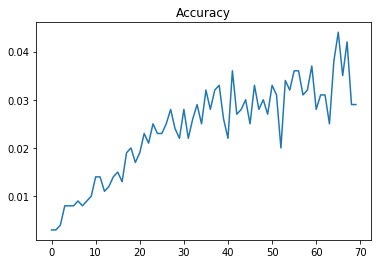

In [19]:
plt.title("Accuracy")
plt.plot(accuracies)

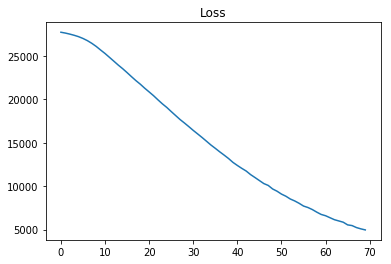

In [20]:
plt.title("Loss")
plt.plot(epoch_losses)

In [21]:
validate("test")

0.042

In [23]:
print(model)

DAN(
  (word_embeddings): Embedding(400000, 300)
  (confidences): ConfidenceLearner(
    (transform): Linear(in_features=301, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2)
  (h1): Linear(in_features=300, out_features=1000, bias=True)
  (h2): Linear(in_features=1000, out_features=1021, bias=True)
)
